
Analyzing image: C:\Users\HP\Documents\GitHub\-Soil-Organic-Matter-Estimation\dataset\Soil types\Cinder Soil\23.jpg

Average Soil Color Values:
H = 0.52, S = 0.17, I = 0.19

Soil Color Percentages:
Cluster 0: 1.5%
Cluster 1: 50.3%
Cluster 2: 48.1%

Cluster Centers (HSI):
Cluster 0: H = 0.57, S = 0.79, I = 0.06
Cluster 1: H = 0.38, S = 0.02, I = 0.68
Cluster 2: H = 0.55, S = 0.13, I = 0.22
Results saved successfully in results\soil_analysis.csv


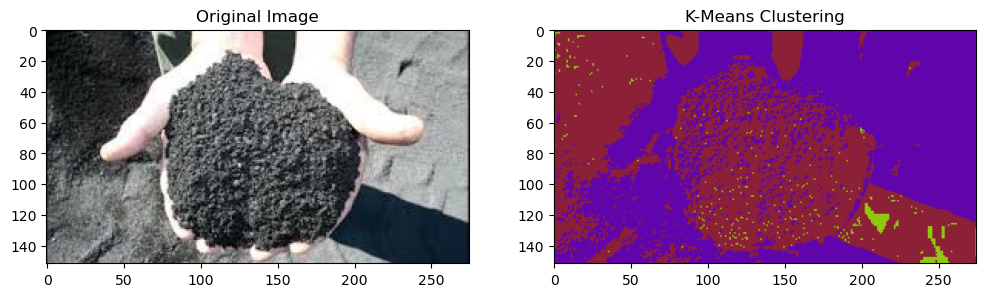

In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ฟังก์ชันแปลง RGB → HSI
def rgb_to_hsi(image):
    image = image.astype(np.float32) / 255.0  # Normalize RGB
    r, g, b = cv2.split(image)

    # คำนวณ Intensity
    I = (r + g + b) / 3

    # คำนวณ Saturation
    min_rgb = np.minimum(np.minimum(r, g), b)
    S = 1 - (min_rgb / (I + 1e-6))  # ป้องกันหารด้วย 0

    # คำนวณ Hue
    num = 0.5 * ((r - g) + (r - b))
    den = np.sqrt((r - g) ** 2 + (r - b) * (g - b)) + 1e-6  # ป้องกันหารด้วย 0
    theta = np.arccos(num / den)

    H = np.where(b > g, 2 * np.pi - theta, theta)
    H = H / (2 * np.pi)  # ปรับให้ค่า H อยู่ในช่วง 0-1

    hsi_image = cv2.merge([H, S, I])
    return hsi_image

# ฟังก์ชันโหลดและแปลงภาพ
def load_and_convert_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"ไม่พบไฟล์: {image_path}")

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsi_image = rgb_to_hsi(image)
    return image, hsi_image

# ฟังก์ชันลบพื้นหลัง
def remove_background(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    result = cv2.bitwise_and(image, image, mask=mask)
    return result, mask

# ฟังก์ชันวิเคราะห์ค่าเฉลี่ยของ HSI
def analyze_soil_color(hsi_image, mask):
    h, s, i = cv2.split(hsi_image)
    mean_H = np.mean(h[mask > 0])
    mean_S = np.mean(s[mask > 0])
    mean_I = np.mean(i[mask > 0])
    return mean_H, mean_S, mean_I

# ฟังก์ชัน K-Means Clustering
def kmeans_clustering(hsi_image, k=3):
    pixels = hsi_image.reshape((-1, 3))
    pixels = np.float32(pixels)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(hsi_image.shape)

    return segmented_image, labels, centers

# ฟังก์ชันคำนวณเปอร์เซ็นต์ของแต่ละสี
def calculate_color_percentage(labels, k):
    unique, counts = np.unique(labels, return_counts=True)
    total_pixels = np.sum(counts)
    percentages = {f'Cluster {i}': (counts[i] / total_pixels) * 100 for i in range(k)}
    return percentages

#  ฟังก์ชันบันทึกผลลัพธ์
def save_results(image_name, mean_H, mean_S, mean_I, percentages, centers, output_dir="results"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    output_csv = os.path.join(output_dir, "soil_analysis.csv")
    
    df_color = pd.DataFrame({
        "Image": [image_name],
        "H": [mean_H], "S": [mean_S], "I": [mean_I]
    })
    
    df_percentage = pd.DataFrame(list(percentages.items()), columns=["Cluster", "Percentage"])
    df_percentage["Image"] = image_name

    df_color.to_csv(output_csv, mode='a', header=not os.path.exists(output_csv), index=False)
    df_percentage.to_csv(output_csv.replace(".csv", "_clusters.csv"), mode='a', header=not os.path.exists(output_csv.replace(".csv", "_clusters.csv")), index=False)

    print(f"Results saved successfully in {output_csv}")

# กำหนดพาธรูปภาพ
BASE_PATH = os.path.normpath("C:/Users/HP/Documents/GitHub/-Soil-Organic-Matter-Estimation/dataset/Soil types")
SOIL_TYPE = "Cinder Soil"
IMAGE_NAME = "23.jpg"
IMAGE_PATH = os.path.join(BASE_PATH, SOIL_TYPE, IMAGE_NAME)


# วิเคราะห์ภาพดิน
original, hsi_image = load_and_convert_image(IMAGE_PATH)
clean_image, mask = remove_background(original)
mean_H, mean_S, mean_I = analyze_soil_color(hsi_image, mask)
segmented_image, labels, centers = kmeans_clustering(hsi_image, k=3)
percentages = calculate_color_percentage(labels, k=3)

# แสดงผล
print(f"\nAnalyzing image: {IMAGE_PATH}\n")
print(f"Average Soil Color Values:\nH = {mean_H:.2f}, S = {mean_S:.2f}, I = {mean_I:.2f}\n")
print("Soil Color Percentages:")
for cluster, percent in percentages.items():
    print(f"{cluster}: {percent:.1f}%")

print("\nCluster Centers (HSI):")
for i, center in enumerate(centers):
    print(f"Cluster {i}: H = {center[0]:.2f}, S = {center[1]:.2f}, I = {center[2]:.2f}")

# บันทึกผลลัพธ์
save_results(IMAGE_NAME, mean_H, mean_S, mean_I, percentages, centers)

# แสดงผลภาพ
plot_results(original, segmented_image, percentages)
